**Ali Asghar**

**5122740**

**Portfolio3 Coding**

1.**Implementation of Basic Strategy Environment and its RL Agents**










In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

class BlackjackEnvironment:
    def __init__(self):
        self.deck = self.generate_deck()
        self.player_hand = []
        self.dealer_hand = []
        self.bankroll = 100
        self.bet = 20
        self.is_playing = False
        self.episode = []

    def generate_deck(self):
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        values = list(range(2, 11)) + ['jack', 'queen', 'king', 'ace']
        deck = []
        for value in values:
            for suit in suits:
                card = str(value) + '_' + suit
                deck.append(card)
        return deck

    def draw_card(self):
        if len(self.deck) == 0:
            self.check_deck()
        card = self.deck.pop(random.randint(0, len(self.deck) - 1))
        return card

    def check_deck(self):
        if len(self.deck) == 0:
            self.deck = self.generate_deck()
            random.shuffle(self.deck)

    def reset(self):
        self.deck = self.generate_deck()
        random.shuffle(self.deck)
        self.player_hand = [self.draw_card(), self.draw_card()]
        self.dealer_hand = [self.draw_card(), self.draw_card()]
        self.bet = 20
        self.episode = []

    def card_value(self, card):
        value = card.split('_')[0]
        if value in ['jack', 'queen', 'king']:
            return 10
        elif value == 'ace':
            return 11
        else:
            return int(value)

    def hand_value(self, hand):
        value = sum(self.card_value(card) for card in hand)
        num_aces = sum(1 for card in hand if card.startswith('ace'))

        while value > 21 and num_aces > 0:
            value -= 10
            num_aces -= 1

        if num_aces > 0 and value > 21:
            value -= 10

        return value

    def is_busted(self, hand):
        return self.hand_value(hand) > 21

    def dealer_play(self):
        while self.hand_value(self.dealer_hand) < 17:
            self.dealer_hand.append(self.draw_card())

    def offer_insurance(self):
        player_value = self.hand_value(self.player_hand)
        dealer_upcard = self.card_value(self.dealer_hand[0])

        if player_value == 21 and dealer_upcard == 11:
            self.bankroll += self.bet * 1.5
            self.insurance_bet = 0
        elif dealer_upcard == 11:
            num_tens = sum(1 for card in self.deck if self.card_value(card) == 10)
            num_remaining_cards = len(self.deck)
            insurance_threshold = num_tens / num_remaining_cards

            if insurance_threshold > 0.3:
                insurance_amount = min(self.bankroll, self.bet / 2)
                self.bankroll -= insurance_amount
                self.insurance_bet = insurance_amount
                if self.hand_value(self.dealer_hand) == 21:
                    self.bankroll += self.insurance_bet * 2
                else:
                    pass
            else:
                self.insurance_bet = 0

    def double_down(self):
        if self.bet <= self.bankroll:
            self.bet *= 2
            self.player_hand.append(self.draw_card())

            if self.is_busted(self.player_hand):
                self.bankroll -= self.bet
                self.episode.append((self.get_state(), 'double_down', -1))
            else:
                self.dealer_play()
                player_value = self.hand_value(self.player_hand)
                dealer_value = self.hand_value(self.dealer_hand)

                if self.is_busted(self.dealer_hand) or player_value > dealer_value:
                    self.bankroll += self.bet
                    self.episode.append((self.get_state(), 'double_down', 1))
                elif dealer_value > player_value:
                    self.bankroll -= self.bet
                    self.episode.append((self.get_state(), 'double_down', -1))
                else:
                    self.episode.append((self.get_state(), 'double_down', 0))
        else:
            pass

    def place_bet(self):
        self.bet = 20

    def split_pair(self):
        if len(self.player_hand) == 2 and self.card_value(self.player_hand[0]) == self.card_value(self.player_hand[1]):
            card_value = self.card_value(self.player_hand[0])
            print(f"Splitting {card_value}'s...")
            hand1 = [self.player_hand[0], self.draw_card()]
            hand2 = [self.player_hand[1], self.draw_card()]
            self.player_hand = [hand1, hand2]
        else:
            pass

    def hit(self):
        self.player_hand.append(self.draw_card())

    def stand(self):
        self.dealer_play()
        player_value = self.hand_value(self.player_hand)
        dealer_value = self.hand_value(self.dealer_hand)

        if self.is_busted(self.dealer_hand):
            self.bankroll += self.bet
            self.episode.append((self.get_state(), 'stand', 1))
        elif player_value > dealer_value:
            self.bankroll += self.bet
            self.episode.append((self.get_state(), 'stand', 1))
        elif dealer_value > player_value:
            self.bankroll -= self.bet
            self.episode.append((self.get_state(), 'stand', -1))
        else:
            self.episode.append((self.get_state(), 'stand', 0))

    def get_state(self):
        return tuple(self.player_hand), self.dealer_hand[0]

    def play_hand(self, hand):
        while True:
            if isinstance(hand[0], list):
                for subhand in hand:
                    self.play_hand(subhand)
                break

            player_value = self.hand_value(hand)
            dealer_upcard = self.card_value(self.dealer_hand[0])

            if player_value <= 8:
                hand.append(self.draw_card())
                if self.is_busted(hand):
                    self.bankroll -= min(self.bankroll, self.bet)
                    self.episode.append((self.get_state(), 'hit', -1))
                    break

            elif player_value >= 17:
                self.dealer_play()
                if self.is_busted(self.dealer_hand):
                    self.bankroll += self.bet
                    self.episode.append((self.get_state(), 'stand', 1))
                else:
                    player_value = self.hand_value(hand)
                    dealer_value = self.hand_value(self.dealer_hand)
                    if player_value > dealer_value:
                        self.bankroll += self.bet
                        self.episode.append((self.get_state(), 'stand', 1))
                    elif dealer_value > player_value:
                        self.bankroll -= min(self.bankroll, self.bet)
                        self.episode.append((self.get_state(), 'stand', -1))
                    else:
                        self.episode.append((self.get_state(), 'stand', 0))
                break

            elif 2 <= dealer_upcard <= 6:
                self.dealer_play()
                if self.is_busted(self.dealer_hand):
                    self.bankroll += self.bet
                    self.episode.append((self.get_state(), 'stand', 1))
                else:
                    player_value = self.hand_value(hand)
                    dealer_value = self.hand_value(self.dealer_hand)
                    if player_value > dealer_value:
                        self.bankroll += self.bet
                        self.episode.append((self.get_state(), 'stand', 1))
                    elif dealer_value > player_value:
                        self.bankroll -= min(self.bankroll, self.bet)
                        self.episode.append((self.get_state(), 'stand', -1))
                    else:
                        self.episode.append((self.get_state(), 'stand', 0))
                break

            elif player_value == 9 or player_value == 10 or player_value == 11:
                self.double_down()
                self.episode.append((self.get_state(), 'double_down', 1))
                break

            elif player_value == self.card_value(hand[0]):
                self.split_pair()
                self.episode.append((self.get_state(), 'split', 0))

                for subhand in self.player_hand:
                    self.episode.append((self.get_state(), 'split', 0))
                    self.play_hand(subhand)
                break

            else:
                hand.append(self.draw_card())
                if self.is_busted(hand):
                    self.bankroll -= min(self.bankroll, self.bet)
                    self.episode.append((self.get_state(), 'hit', -1))
                    break

        return self.bankroll

    def get_episode(self):
        return [self.episode]

    def play(self, num_episodes, epsilon, agent):
        print("Welcome to Blackjack!")
        print(f"Your current bankroll: {self.bankroll}")
        self.is_playing = True
        current_episode = 0
        all_episodes = []
        rewards_per_episode = []  # To store rewards per episode

        for _ in range(num_episodes):
            self.reset()
            self.place_bet()
            final_bankroll = self.play_hand(self.player_hand)
            episode = self.get_episode()
            all_episodes.extend(episode)
            rewards_per_episode.append(final_bankroll - 100)  # Calculate reward per episode

            if _ < num_episodes - 1:
                self.episode = []

        print("\nThank you for playing Blackjack!")
        print(f"Final Bankroll: {self.bankroll}")

        current_episode = _ + 1
        agent.update_policy(all_episodes)

        return all_episodes, rewards_per_episode

    def calculate_performance_metrics(self, num_episodes):
        total_bankroll = 0
        total_winnings = 0
        total_wins = 0

        for _ in range(num_episodes):
            self.reset()
            self.place_bet()
            self.play_hand(self.player_hand)

            total_bankroll += self.bankroll
            total_winnings += self.bankroll - 100
            if self.bankroll > 100:
                total_wins += 1

        average_bankroll = total_bankroll / num_episodes
        win_rate = total_wins / num_episodes
        average_winnings = total_winnings / num_episodes

        return average_bankroll, win_rate, average_winnings

class SARSAAgent:
    def __init__(self, action_space):
        self.action_space = action_space
        self.q_table = {}

    def get_action(self, state, epsilon):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(len(self.action_space))

        if np.random.random() < epsilon:
            action = np.random.choice(self.action_space)
        else:
            action = self.action_space[np.argmax(self.q_table[state])]

        return action

    def update_policy(self, episodes, alpha=0.5, gamma=0.9):
        for episode in episodes:
            for (state, action, reward) in episode:
                if state not in self.q_table:
                    self.q_table[state] = np.zeros(len(self.action_space))

                current_action_index = self.action_space.index(action)
                next_state, next_action, next_reward = episode[-1]

                if next_state not in self.q_table:
                    self.q_table[next_state] = np.zeros(len(self.action_space))

                self.q_table[state][current_action_index] += alpha * (reward + gamma * self.q_table[next_state][self.action_space.index(next_action)] - self.q_table[state][current_action_index])




Discount factor 0.9 and alphs 0.5 (we can set these values in the updated policy of the agent)

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 40
Sarsa Agent - Average Bankroll: 131.0202
Sarsa Agent - Win Rate: 0.43519
Sarsa Agent - Average Winnings: 31.0202


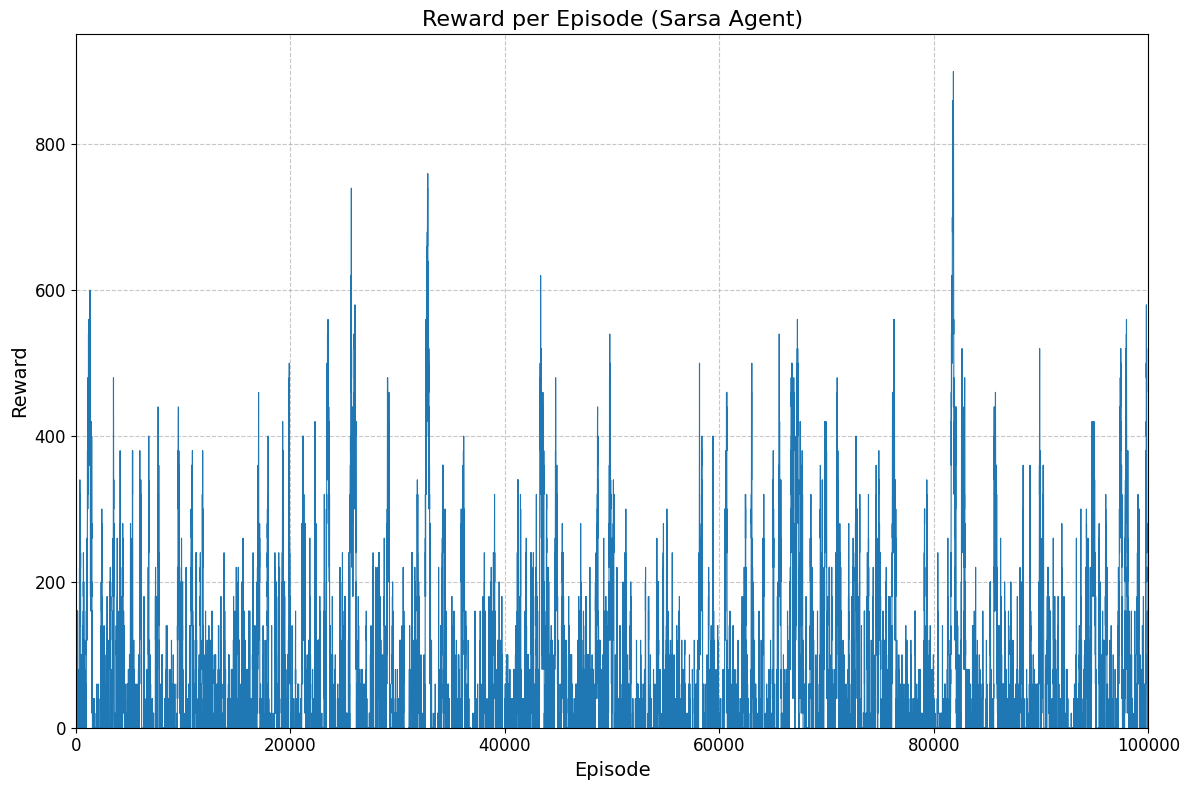

In [ ]:
import matplotlib.pyplot as plt

def run_simulation(env, agent, num_episodes, epsilon, agent_name):
    all_episodes, rewards_per_episode = env.play(num_episodes, epsilon, agent)

    average_bankroll, win_rate, average_winnings = env.calculate_performance_metrics(num_episodes)

    print(f"{agent_name} - Average Bankroll: {average_bankroll:.4f}")
    print(f"{agent_name} - Win Rate: {win_rate:.5f}")
    print(f"{agent_name} - Average Winnings: {average_winnings:.4f}")

    plt.figure(figsize=(12, 8))
    plt.plot(range(1, num_episodes + 1), rewards_per_episode, color='#1f77b4', linewidth=0.8)
    plt.title(f"Reward per Episode ({agent_name})", fontsize=16)
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Reward", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.ylim(bottom=0)
    plt.xlim(0, num_episodes)
    plt.tight_layout()
    plt.show()

    return rewards_per_episode

# Main execution
if __name__ == "__main__":
    # Create an instance of the environment
    env = BlackjackEnvironment()

    # Define the TD agent
    action_space = ['hit', 'stand', 'double_down', 'split']
    Sarsa_agent = SARSAAgent(action_space)

    # Define parameters for training
    num_episodes = 100000
    epsilon = 0.1

    # Train the TD agent and plot results
    rewards_td = run_simulation(env, Sarsa_agent, num_episodes, epsilon, "Sarsa Agent")

**Experiments with differnet Discount factor and Epsilon values for SARSA Agent**

with discount factor 0.7 and alpha 0.5 (we can set these values in the updated policy of the agent)

In [ ]:
env = BlackjackEnvironment()

    # Define the TD agent
action_space = ['hit', 'stand', 'double_down', 'split']
Sarsa_agent = SARSAAgent(action_space)

    # Define parameters for training
num_episodes = 100000
epsilon = 0.1
all_episodes, rewards_per_episode = env.play(num_episodes, epsilon, Sarsa_agent)

average_bankroll, win_rate, average_winnings = env.calculate_performance_metrics(num_episodes)

print(f"{Sarsa_agent} - Average Bankroll: {average_bankroll:.4f}")
print(f"{Sarsa_agent} - Win Rate: {win_rate:.5f}")
print(f"{Sarsa_agent} - Average Winnings: {average_winnings:.4f}")


Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 0
<__main__.SARSAAgent object at 0x7ed3ca7e30d0> - Average Bankroll: 117.1846
<__main__.SARSAAgent object at 0x7ed3ca7e30d0> - Win Rate: 0.39402
<__main__.SARSAAgent object at 0x7ed3ca7e30d0> - Average Winnings: 17.1846


Discount factor 0.8 and alpha 0.5

In [ ]:
env = BlackjackEnvironment()

    # Define the TD agent
action_space = ['hit', 'stand', 'double_down', 'split']
Sarsa_agent = SARSAAgent(action_space)

    # Define parameters for training
num_episodes = 100000
epsilon = 0.1
all_episodes, rewards_per_episode = env.play(num_episodes, epsilon, Sarsa_agent)

average_bankroll, win_rate, average_winnings = env.calculate_performance_metrics(num_episodes)

print(f"{Sarsa_agent} - Average Bankroll: {average_bankroll:.4f}")
print(f"{Sarsa_agent} - Win Rate: {win_rate:.5f}")
print(f"{Sarsa_agent} - Average Winnings: {average_winnings:.4f}")


Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 0
<__main__.SARSAAgent object at 0x7ed3f1956d70> - Average Bankroll: 131.2548
<__main__.SARSAAgent object at 0x7ed3f1956d70> - Win Rate: 0.42398
<__main__.SARSAAgent object at 0x7ed3f1956d70> - Average Winnings: 31.2548


Discount Factor 0.99 and alpha 0.5

In [ ]:
env = BlackjackEnvironment()

    # Define the TD agent
action_space = ['hit', 'stand', 'double_down', 'split']
Sarsa_agent = SARSAAgent(action_space)

    # Define parameters for training
num_episodes = 100000
epsilon = 0.1
all_episodes, rewards_per_episode = env.play(num_episodes, epsilon, Sarsa_agent)

average_bankroll, win_rate, average_winnings = env.calculate_performance_metrics(num_episodes)

print(f"{Sarsa_agent} - Average Bankroll: {average_bankroll:.4f}")
print(f"{Sarsa_agent} - Win Rate: {win_rate:.5f}")
print(f"{Sarsa_agent} - Average Winnings: {average_winnings:.4f}")


Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 0
<__main__.SARSAAgent object at 0x7ed3c25378e0> - Average Bankroll: 123.1408
<__main__.SARSAAgent object at 0x7ed3c25378e0> - Win Rate: 0.39195
<__main__.SARSAAgent object at 0x7ed3c25378e0> - Average Winnings: 23.1408


**TD(Temporal Difference) Agent (off-policy)**

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

class BlackjackEnvironment:
    def __init__(self):
        self.deck = self.generate_deck()
        self.player_hand = []
        self.dealer_hand = []
        self.bankroll = 100
        self.bet = 20
        self.is_playing = False
        self.episode = []

    def generate_deck(self):
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        values = list(range(2, 11)) + ['jack', 'queen', 'king', 'ace']
        deck = []
        for value in values:
            for suit in suits:
                card = str(value) + '_' + suit
                deck.append(card)
        return deck

    def draw_card(self):
        if len(self.deck) == 0:
            self.check_deck()
        card = self.deck.pop(random.randint(0, len(self.deck) - 1))
        return card

    def check_deck(self):
        if len(self.deck) == 0:
            self.deck = self.generate_deck()
            random.shuffle(self.deck)

    def reset(self):
        self.deck = self.generate_deck()
        random.shuffle(self.deck)
        self.player_hand = [self.draw_card(), self.draw_card()]
        self.dealer_hand = [self.draw_card(), self.draw_card()]
        self.bet = 20
        self.episode = []

    def card_value(self, card):
        value = card.split('_')[0]
        if value in ['jack', 'queen', 'king']:
            return 10
        elif value == 'ace':
            return 11
        else:
            return int(value)

    def hand_value(self, hand):
        value = sum(self.card_value(card) for card in hand)
        num_aces = sum(1 for card in hand if card.startswith('ace'))

        while value > 21 and num_aces > 0:
            value -= 10
            num_aces -= 1

        if num_aces > 0 and value > 21:
            value -= 10

        return value

    def is_busted(self, hand):
        return self.hand_value(hand) > 21

    def dealer_play(self):
        while self.hand_value(self.dealer_hand) < 17:
            self.dealer_hand.append(self.draw_card())

    def offer_insurance(self):
        player_value = self.hand_value(self.player_hand)
        dealer_upcard = self.card_value(self.dealer_hand[0])

        if player_value == 21 and dealer_upcard == 11:
            self.bankroll += self.bet * 1.5
            self.insurance_bet = 0
        elif dealer_upcard == 11:
            num_tens = sum(1 for card in self.deck if self.card_value(card) == 10)
            num_remaining_cards = len(self.deck)
            insurance_threshold = num_tens / num_remaining_cards

            if insurance_threshold > 0.3:
                insurance_amount = min(self.bankroll, self.bet / 2)
                self.bankroll -= insurance_amount
                self.insurance_bet = insurance_amount
                if self.hand_value(self.dealer_hand) == 21:
                    self.bankroll += self.insurance_bet * 2
                else:
                    pass
            else:
                self.insurance_bet = 0

    def double_down(self):
        if self.bet <= self.bankroll:
            self.bet *= 2
            self.player_hand.append(self.draw_card())

            if self.is_busted(self.player_hand):
                self.bankroll -= self.bet
                self.episode.append((self.get_state(), 'double_down', -1))
            else:
                self.dealer_play()
                player_value = self.hand_value(self.player_hand)
                dealer_value = self.hand_value(self.dealer_hand)

                if self.is_busted(self.dealer_hand) or player_value > dealer_value:
                    self.bankroll += self.bet
                    self.episode.append((self.get_state(), 'double_down', 1))
                elif dealer_value > player_value:
                    self.bankroll -= self.bet
                    self.episode.append((self.get_state(), 'double_down', -1))
                else:
                    self.episode.append((self.get_state(), 'double_down', 0))
        else:
            pass

    def place_bet(self):
        self.bet = 20

    def split_pair(self):
        if len(self.player_hand) == 2 and self.card_value(self.player_hand[0]) == self.card_value(self.player_hand[1]):
            card_value = self.card_value(self.player_hand[0])
            print(f"Splitting {card_value}'s...")
            hand1 = [self.player_hand[0], self.draw_card()]
            hand2 = [self.player_hand[1], self.draw_card()]
            self.player_hand = [hand1, hand2]
        else:
            pass

    def hit(self):
        self.player_hand.append(self.draw_card())

    def stand(self):
        self.dealer_play()
        player_value = self.hand_value(self.player_hand)
        dealer_value = self.hand_value(self.dealer_hand)

        if self.is_busted(self.dealer_hand):
            self.bankroll += self.bet
            self.episode.append((self.get_state(), 'stand', 1))
        elif player_value > dealer_value:
            self.bankroll += self.bet
            self.episode.append((self.get_state(), 'stand', 1))
        elif dealer_value > player_value:
            self.bankroll -= self.bet
            self.episode.append((self.get_state(), 'stand', -1))
        else:
            self.episode.append((self.get_state(), 'stand', 0))

    def get_state(self):
        return tuple(self.player_hand), self.dealer_hand[0]

    def play_hand(self, hand):
        while True:
            if isinstance(hand[0], list):
                for subhand in hand:
                    self.play_hand(subhand)
                break

            player_value = self.hand_value(hand)
            dealer_upcard = self.card_value(self.dealer_hand[0])

            if player_value <= 8:
                hand.append(self.draw_card())
                if self.is_busted(hand):
                    self.bankroll -= min(self.bankroll, self.bet)
                    self.episode.append((self.get_state(), 'hit', -1))
                    break

            elif player_value >= 17:
                self.dealer_play()
                if self.is_busted(self.dealer_hand):
                    self.bankroll += self.bet
                    self.episode.append((self.get_state(), 'stand', 1))
                else:
                    player_value = self.hand_value(hand)
                    dealer_value = self.hand_value(self.dealer_hand)
                    if player_value > dealer_value:
                        self.bankroll += self.bet
                        self.episode.append((self.get_state(), 'stand', 1))
                    elif dealer_value > player_value:
                        self.bankroll -= min(self.bankroll, self.bet)
                        self.episode.append((self.get_state(), 'stand', -1))
                    else:
                        self.episode.append((self.get_state(), 'stand', 0))
                break

            elif 2 <= dealer_upcard <= 6:
                self.dealer_play()
                if self.is_busted(self.dealer_hand):
                    self.bankroll += self.bet
                    self.episode.append((self.get_state(), 'stand', 1))
                else:
                    player_value = self.hand_value(hand)
                    dealer_value = self.hand_value(self.dealer_hand)
                    if player_value > dealer_value:
                        self.bankroll += self.bet
                        self.episode.append((self.get_state(), 'stand', 1))
                    elif dealer_value > player_value:
                        self.bankroll -= min(self.bankroll, self.bet)
                        self.episode.append((self.get_state(), 'stand', -1))
                    else:
                        self.episode.append((self.get_state(), 'stand', 0))
                break

            elif player_value == 9 or player_value == 10 or player_value == 11:
                self.double_down()
                self.episode.append((self.get_state(), 'double_down', 1))
                break

            elif player_value == self.card_value(hand[0]):
                self.split_pair()
                self.episode.append((self.get_state(), 'split', 0))

                for subhand in self.player_hand:
                    self.episode.append((self.get_state(), 'split', 0))
                    self.play_hand(subhand)
                break

            else:
                hand.append(self.draw_card())
                if self.is_busted(hand):
                    self.bankroll -= min(self.bankroll, self.bet)
                    self.episode.append((self.get_state(), 'hit', -1))
                    break

        return self.bankroll

    def get_episode(self):
        return [self.episode]

    def play(self, num_episodes, epsilon, agent):
        print("Welcome to Blackjack!")
        print(f"Your current bankroll: {self.bankroll}")
        self.is_playing = True
        current_episode = 0
        all_episodes = []
        rewards_per_episode = []

        for _ in range(num_episodes):
            self.reset()
            self.place_bet()
            final_bankroll = self.play_hand(self.player_hand)
            episode = self.get_episode()
            all_episodes.extend(episode)
            rewards_per_episode.append(final_bankroll - 100)

            if _ < num_episodes - 1:
                self.episode = []

        print("\nThank you for playing Blackjack!")
        print(f"Final Bankroll: {self.bankroll}")

        current_episode = _ + 1
        agent.update_policy(all_episodes)

        return all_episodes, rewards_per_episode

    def calculate_performance_metrics(self, num_episodes):
        total_bankroll = 0
        total_winnings = 0
        total_wins = 0

        for _ in range(num_episodes):
            self.reset()
            self.place_bet()
            self.play_hand(self.player_hand)

            total_bankroll += self.bankroll
            total_winnings += self.bankroll - 100
            if self.bankroll > 100:
                total_wins += 1

        average_bankroll = total_bankroll / num_episodes
        win_rate = total_wins / num_episodes
        average_winnings = total_winnings / num_episodes

        return average_bankroll, win_rate, average_winnings

class TDAgent:
    def __init__(self, action_space):
        self.action_space = action_space
        self.value_table = {}

    def get_action(self, state, epsilon):
        if state not in self.value_table:
            self.value_table[state] = np.zeros(len(self.action_space))

        if np.random.random() < epsilon:
            action = np.random.choice(self.action_space)
        else:
            action = self.action_space[np.argmax(self.value_table[state])]

        return action

    def update_policy(self, episodes, alpha=0.5, gamma=0.9):
        for episode in episodes:
            for (state, action, reward) in episode:
                if state not in self.value_table:
                    self.value_table[state] = np.zeros(len(self.action_space))

                current_action_index = self.action_space.index(action)
                next_state, next_action, next_reward = episode[-1]

                if next_state not in self.value_table:
                    self.value_table[next_state] = np.zeros(len(self.action_space))

                td_target = reward + gamma * np.max(self.value_table[next_state])
                td_error = td_target - self.value_table[state][current_action_index]
                self.value_table[state][current_action_index] += alpha * td_error



Discount Factor 0.9 and alpha value 0.5 (we can set these parameters in the Agent policy update function)  

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 0
TD Agent - Average Bankroll: 122.3382
TD Agent - Win Rate: 0.39063
TD Agent - Average Winnings: 22.3382


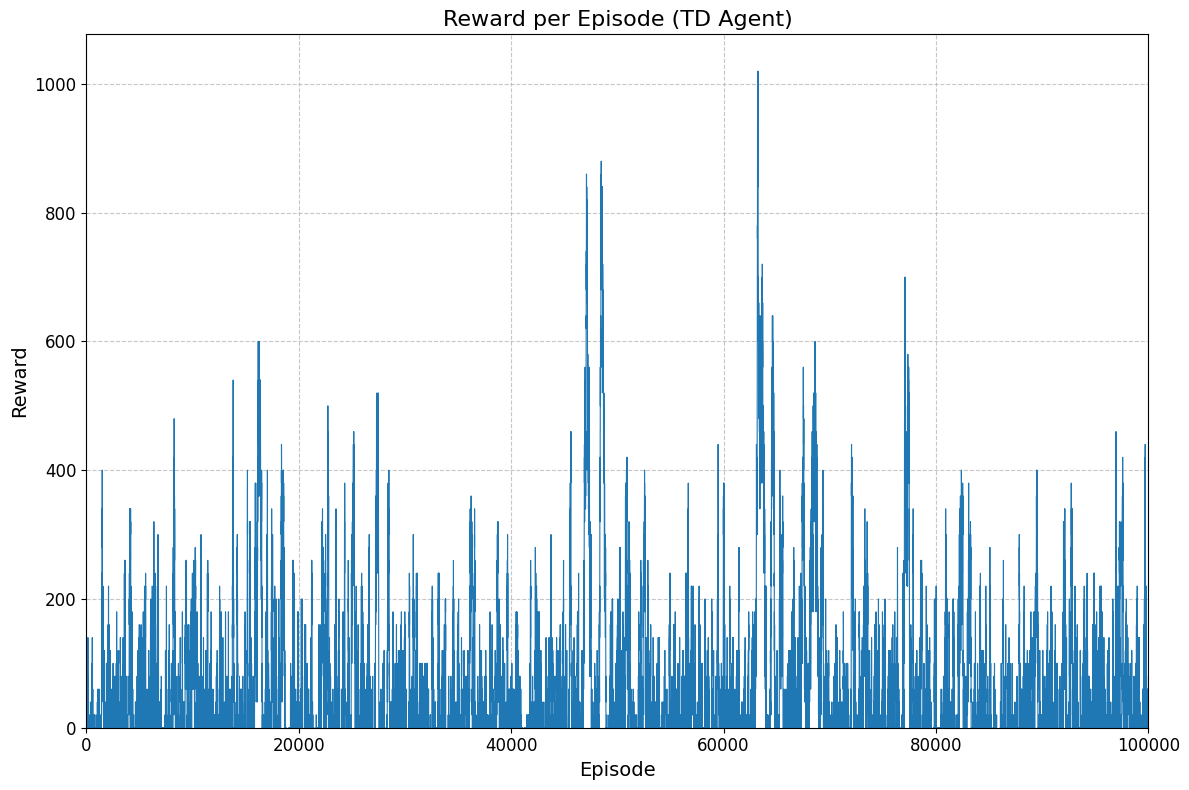

In [ ]:
import matplotlib.pyplot as plt

def run_simulation(env, agent, num_episodes, epsilon, agent_name):
    all_episodes, rewards_per_episode = env.play(num_episodes, epsilon, agent)

    average_bankroll, win_rate, average_winnings = env.calculate_performance_metrics(num_episodes)

    print(f"{agent_name} - Average Bankroll: {average_bankroll:.4f}")
    print(f"{agent_name} - Win Rate: {win_rate:.5f}")
    print(f"{agent_name} - Average Winnings: {average_winnings:.4f}")

    plt.figure(figsize=(12, 8))
    plt.plot(range(1, num_episodes + 1), rewards_per_episode, color='#1f77b4', linewidth=0.8)
    plt.title(f"Reward per Episode ({agent_name})", fontsize=16)
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Reward", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.ylim(bottom=0)
    plt.xlim(0, num_episodes)
    plt.tight_layout()
    plt.show()

    return rewards_per_episode

# Main execution
if __name__ == "__main__":
    # Create an instance of the environment
    env = BlackjackEnvironment()

    # Define the TD agent
    action_space = ['hit', 'stand', 'double_down', 'split']
    td_agent = TDAgent(action_space)

    # Define parameters for training
    num_episodes = 100000
    epsilon = 0.1

    # Train the TD agent and plot results
    rewards_td = run_simulation(env, td_agent, num_episodes, epsilon, "TD Agent")

Experiment with different Discount factor and Alpha values for TD agent

Discount factor 0.7 and alpha value 0.5

In [ ]:
env = BlackjackEnvironment()

    # Define the TD agent
action_space = ['hit', 'stand', 'double_down', 'split']
td_agent = TDAgent(action_space)

    # Define parameters for training
num_episodes = 100000
epsilon = 0.1



all_episodes, rewards_per_episode = env.play(num_episodes, epsilon, td_agent)

average_bankroll, win_rate, average_winnings = env.calculate_performance_metrics(num_episodes)

print(f"{td_agent} - Average Bankroll: {average_bankroll:.4f}")
print(f"{td_agent} - Win Rate: {win_rate:.5f}")
print(f"{td_agent} - Average Winnings: {average_winnings:.4f}")


Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 60
<__main__.TDAgent object at 0x7ed3ca7e38e0> - Average Bankroll: 129.9382
<__main__.TDAgent object at 0x7ed3ca7e38e0> - Win Rate: 0.41591
<__main__.TDAgent object at 0x7ed3ca7e38e0> - Average Winnings: 29.9382


Discount factor 0.8 and alphs 0.5

In [ ]:
env = BlackjackEnvironment()

    # Define the TD agent
action_space = ['hit', 'stand', 'double_down', 'split']
td_agent = TDAgent(action_space)

    # Define parameters for training
num_episodes = 100000
epsilon = 0.1



all_episodes, rewards_per_episode = env.play(num_episodes, epsilon, td_agent)

average_bankroll, win_rate, average_winnings = env.calculate_performance_metrics(num_episodes)

print(f"{td_agent} - Average Bankroll: {average_bankroll:.4f}")
print(f"{td_agent} - Win Rate: {win_rate:.5f}")
print(f"{td_agent} - Average Winnings: {average_winnings:.4f}")


Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 120
<__main__.TDAgent object at 0x7ed3f18b8ac0> - Average Bankroll: 125.1582
<__main__.TDAgent object at 0x7ed3f18b8ac0> - Win Rate: 0.41319
<__main__.TDAgent object at 0x7ed3f18b8ac0> - Average Winnings: 25.1582


Discount Factor 0.99 and alpha value 0.5

In [ ]:
env = BlackjackEnvironment()

    # Define the TD agent
action_space = ['hit', 'stand', 'double_down', 'split']
td_agent = TDAgent(action_space)

    # Define parameters for training
num_episodes = 100000
epsilon = 0.1



all_episodes, rewards_per_episode = env.play(num_episodes, epsilon, td_agent)

average_bankroll, win_rate, average_winnings = env.calculate_performance_metrics(num_episodes)

print(f"{td_agent} - Average Bankroll: {average_bankroll:.4f}")
print(f"{td_agent} - Win Rate: {win_rate:.5f}")
print(f"{td_agent} - Average Winnings: {average_winnings:.4f}")


Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 300
<__main__.TDAgent object at 0x7ed3ca7e0d30> - Average Bankroll: 118.6194
<__main__.TDAgent object at 0x7ed3ca7e0d30> - Win Rate: 0.40364
<__main__.TDAgent object at 0x7ed3ca7e0d30> - Average Winnings: 18.6194


**Monte Carlo On-Policy and Off-Policy Agents for Basic Strategy Environment**

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

class BlackjackEnvironment:
    def __init__(self):
        self.deck = self.generate_deck()
        self.player_hand = []
        self.dealer_hand = []
        self.bankroll = 100
        self.bet = 20
        self.is_playing = False
        self.episode = []

    def generate_deck(self):
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        values = list(range(2, 11)) + ['jack', 'queen', 'king', 'ace']
        deck = []
        for value in values:
            for suit in suits:
                card = str(value) + '_' + suit
                deck.append(card)
        return deck

    def draw_card(self):
        if len(self.deck) == 0:
            self.check_deck()
        card = self.deck.pop(random.randint(0, len(self.deck) - 1))
        return card

    def check_deck(self):
        if len(self.deck) == 0:
            self.deck = self.generate_deck()
            random.shuffle(self.deck)

    def reset(self):
        self.deck = self.generate_deck()
        random.shuffle(self.deck)
        self.player_hand = [self.draw_card(), self.draw_card()]
        self.dealer_hand = [self.draw_card(), self.draw_card()]
        self.bet = 20
        self.episode = []

    def card_value(self, card):
        value = card.split('_')[0]
        if value in ['jack', 'queen', 'king']:
            return 10
        elif value == 'ace':
            return 11
        else:
            return int(value)

    def hand_value(self, hand):
        value = sum(self.card_value(card) for card in hand)
        num_aces = sum(1 for card in hand if card.startswith('ace'))

        while value > 21 and num_aces > 0:
            value -= 10
            num_aces -= 1

        if num_aces > 0 and value > 21:
            value -= 10

        return value

    def is_busted(self, hand):
        return self.hand_value(hand) > 21

    def dealer_play(self):
        while self.hand_value(self.dealer_hand) < 17:
            self.dealer_hand.append(self.draw_card())

    def offer_insurance(self):
        player_value = self.hand_value(self.player_hand)
        dealer_upcard = self.card_value(self.dealer_hand[0])

        if player_value == 21 and dealer_upcard == 11:
            self.bankroll += self.bet * 1.5
            self.insurance_bet = 0
        elif dealer_upcard == 11:
            num_tens = sum(1 for card in self.deck if self.card_value(card) == 10)
            num_remaining_cards = len(self.deck)
            insurance_threshold = num_tens / num_remaining_cards

            if insurance_threshold > 0.3:
                insurance_amount = min(self.bankroll, self.bet / 2)
                self.bankroll -= insurance_amount
                self.insurance_bet = insurance_amount
                if self.hand_value(self.dealer_hand) == 21:
                    self.bankroll += self.insurance_bet * 2
                else:
                    pass
            else:
                self.insurance_bet = 0

    def double_down(self):
        if self.bet <= self.bankroll:
            self.bet *= 2
            self.player_hand.append(self.draw_card())

            if self.is_busted(self.player_hand):
                self.bankroll -= self.bet
                self.episode.append((self.get_state(), 'double_down', -1))
            else:
                self.dealer_play()
                player_value = self.hand_value(self.player_hand)
                dealer_value = self.hand_value(self.dealer_hand)

                if self.is_busted(self.dealer_hand) or player_value > dealer_value:
                    self.bankroll += self.bet
                    self.episode.append((self.get_state(), 'double_down', 1))
                elif dealer_value > player_value:
                    self.bankroll -= self.bet
                    self.episode.append((self.get_state(), 'double_down', -1))
                else:
                    self.episode.append((self.get_state(), 'double_down', 0))
        else:
            pass

    def place_bet(self):
        self.bet = 20

    def split_pair(self):
        if len(self.player_hand) == 2 and self.card_value(self.player_hand[0]) == self.card_value(self.player_hand[1]):
            card_value = self.card_value(self.player_hand[0])
            print(f"Splitting {card_value}'s...")
            hand1 = [self.player_hand[0], self.draw_card()]
            hand2 = [self.player_hand[1], self.draw_card()]
            self.player_hand = [hand1, hand2]
        else:
            pass

    def hit(self):
        self.player_hand.append(self.draw_card())

    def stand(self):
        self.dealer_play()
        player_value = self.hand_value(self.player_hand)
        dealer_value = self.hand_value(self.dealer_hand)

        if self.is_busted(self.dealer_hand):
            self.bankroll += self.bet
            self.episode.append((self.get_state(), 'stand', 1))
        elif player_value > dealer_value:
            self.bankroll += self.bet
            self.episode.append((self.get_state(), 'stand', 1))
        elif dealer_value > player_value:
            self.bankroll -= self.bet
            self.episode.append((self.get_state(), 'stand', -1))
        else:
            self.episode.append((self.get_state(), 'stand', 0))

    def get_state(self):
        return tuple(self.player_hand), self.dealer_hand[0]

    def play_hand(self, hand):
        while True:
            if isinstance(hand[0], list):
                for subhand in hand:
                    self.play_hand(subhand)
                break

            player_value = self.hand_value(hand)
            dealer_upcard = self.card_value(self.dealer_hand[0])

            if player_value <= 8:
                hand.append(self.draw_card())
                if self.is_busted(hand):
                    self.bankroll -= min(self.bankroll, self.bet)
                    self.episode.append((self.get_state(), 'hit', -1))
                    break

            elif player_value >= 17:
                self.dealer_play()
                if self.is_busted(self.dealer_hand):
                    self.bankroll += self.bet
                    self.episode.append((self.get_state(), 'stand', 1))
                else:
                    player_value = self.hand_value(hand)
                    dealer_value = self.hand_value(self.dealer_hand)
                    if player_value > dealer_value:
                        self.bankroll += self.bet
                        self.episode.append((self.get_state(), 'stand', 1))
                    elif dealer_value > player_value:
                        self.bankroll -= min(self.bankroll, self.bet)
                        self.episode.append((self.get_state(), 'stand', -1))
                    else:
                        self.episode.append((self.get_state(), 'stand', 0))
                break

            elif 2 <= dealer_upcard <= 6:
                self.dealer_play()
                if self.is_busted(self.dealer_hand):
                    self.bankroll += self.bet
                    self.episode.append((self.get_state(), 'stand', 1))
                else:
                    player_value = self.hand_value(hand)
                    dealer_value = self.hand_value(self.dealer_hand)
                    if player_value > dealer_value:
                        self.bankroll += self.bet
                        self.episode.append((self.get_state(), 'stand', 1))
                    elif dealer_value > player_value:
                        self.bankroll -= min(self.bankroll, self.bet)
                        self.episode.append((self.get_state(), 'stand', -1))
                    else:
                        self.episode.append((self.get_state(), 'stand', 0))
                break

            elif player_value == 9 or player_value == 10 or player_value == 11:
                self.double_down()
                self.episode.append((self.get_state(), 'double_down', 1))
                break

            elif player_value == self.card_value(hand[0]):
                self.split_pair()
                self.episode.append((self.get_state(), 'split', 0))

                for subhand in self.player_hand:
                    self.episode.append((self.get_state(), 'split', 0))
                    self.play_hand(subhand)
                break

            else:
                hand.append(self.draw_card())
                if self.is_busted(hand):
                    self.bankroll -= min(self.bankroll, self.bet)
                    self.episode.append((self.get_state(), 'hit', -1))
                    break

        return self.bankroll

    def get_episode(self):
        return [self.episode]

    def play(self, num_episodes, epsilon, agent):
        print("Welcome to Blackjack!")
        print(f"Your current bankroll: {self.bankroll}")
        self.is_playing = True
        current_episode = 0
        all_episodes = []
        rewards_per_episode = []  # To store rewards per episode

        for _ in range(num_episodes):
            self.reset()
            self.place_bet()
            final_bankroll = self.play_hand(self.player_hand)
            episode = self.get_episode()
            all_episodes.extend(episode)
            rewards_per_episode.append(final_bankroll - 100)  # Calculate reward per episode

            if _ < num_episodes - 1:
                self.episode = []

        print("\nThank you for playing Blackjack!")
        print(f"Final Bankroll: {self.bankroll}")

        current_episode = _ + 1
        agent.update_policy(all_episodes)

        return all_episodes, rewards_per_episode

    def calculate_performance_metrics(self, num_episodes):
        total_bankroll = 0
        total_winnings = 0
        total_wins = 0

        for _ in range(num_episodes):
            self.reset()
            self.place_bet()
            self.play_hand(self.player_hand)

            total_bankroll += self.bankroll
            total_winnings += self.bankroll - 100
            if self.bankroll > 100:
                total_wins += 1

        average_bankroll = total_bankroll / num_episodes
        win_rate = total_wins / num_episodes
        average_winnings = total_winnings / num_episodes

        return average_bankroll, win_rate, average_winnings

**Monte Carlo On-Policy**

In [ ]:
class MonteCarloOnPolicyAgent:
    def __init__(self, action_space):
        self.action_space = action_space
        self.q_table = {}
        self.returns = {}

    def get_action(self, state, epsilon):
        state = self.state_to_key(state)
        if state not in self.q_table:
            self.q_table[state] = np.zeros(len(self.action_space))

        if np.random.random() < epsilon:
            action = np.random.choice(self.action_space)
        else:
            action = self.action_space[np.argmax(self.q_table[state])]

        return action

    def update_policy(self, episodes, gamma=0.9):
        for episode in episodes:
            G = 0
            visited_states_actions = set()
            for state, action, reward in reversed(episode):
                state = self.state_to_key(state)
                G = gamma * G + reward
                sa_pair = (state, action)
                if sa_pair not in visited_states_actions:
                    visited_states_actions.add(sa_pair)
                    if sa_pair not in self.returns:
                        self.returns[sa_pair] = []
                    self.returns[sa_pair].append(G)
                    if state not in self.q_table:
                        self.q_table[state] = np.zeros(len(self.action_space))
                    self.q_table[state][self.action_space.index(action)] = np.mean(self.returns[sa_pair])

    def state_to_key(self, state):
        return (tuple(state[0]), state[1])



Discount Factor 0.9 and alpha value 0.5

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 0
MC On-Policy Agent - Average Bankroll: 118.9130
MC On-Policy Agent - Win Rate: 0.39632
MC On-Policy Agent - Average Winnings: 18.9130


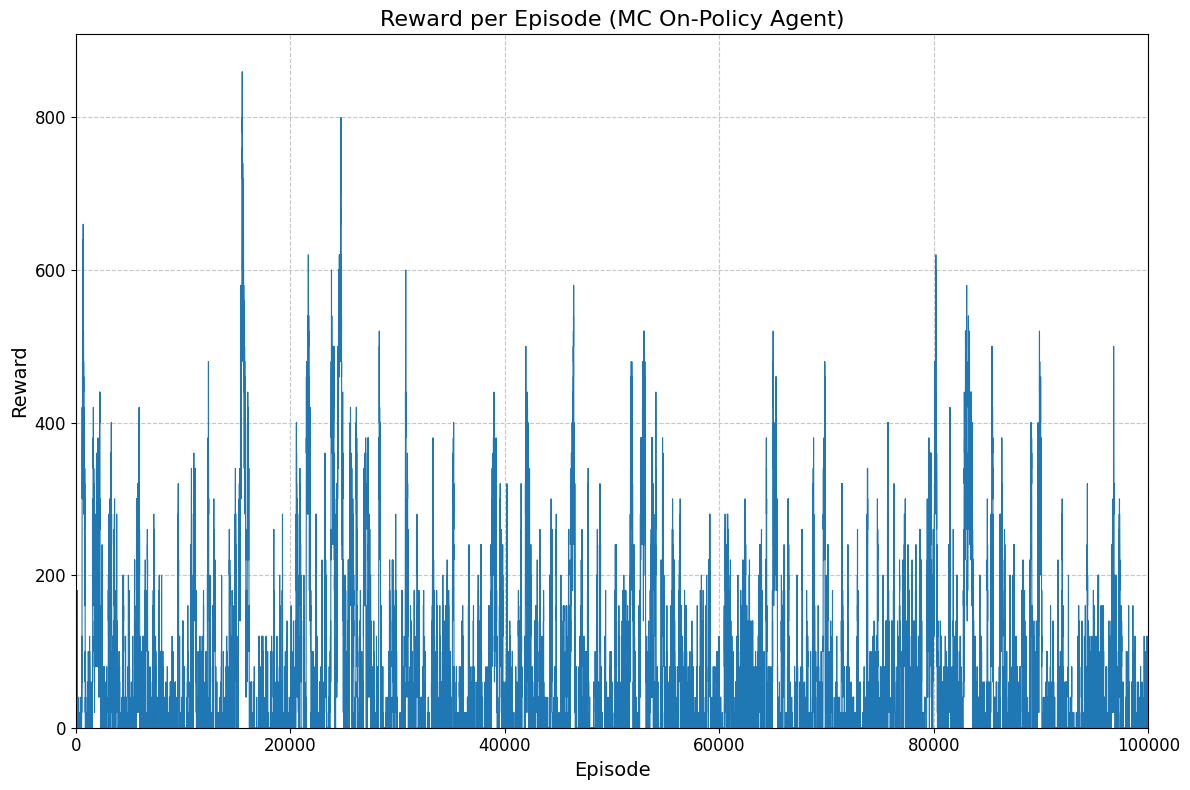

In [ ]:
import matplotlib.pyplot as plt

def run_simulation(env, agent, num_episodes, epsilon, agent_name):
    all_episodes, rewards_per_episode = env.play(num_episodes, epsilon, agent)

    average_bankroll, win_rate, average_winnings = env.calculate_performance_metrics(num_episodes)

    print(f"{agent_name} - Average Bankroll: {average_bankroll:.4f}")
    print(f"{agent_name} - Win Rate: {win_rate:.5f}")
    print(f"{agent_name} - Average Winnings: {average_winnings:.4f}")

    plt.figure(figsize=(12, 8))
    plt.plot(range(1, num_episodes + 1), rewards_per_episode, color='#1f77b4', linewidth=0.8)
    plt.title(f"Reward per Episode ({agent_name})", fontsize=16)
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Reward", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.ylim(bottom=0)
    plt.xlim(0, num_episodes)
    plt.tight_layout()
    plt.show()

    return rewards_per_episode

# Main execution
if __name__ == "__main__":
    env = BlackjackEnvironment()

    # Define the Monte Carlo On-Policy agent
    action_space = ['hit', 'stand', 'double_down', 'split']
    mc_on_policy_agent = MonteCarloOnPolicyAgent(action_space)

    # Define parameters for training
    num_episodes = 100000
    epsilon = 0.1

    # Train the Monte Carlo On-Policy agent and plot results
    rewards_mc_on = run_simulation(env, mc_on_policy_agent, num_episodes, epsilon, "MC On-Policy Agent")

Discount Factor 0.7 and alpha 0.5

In [ ]:
env = BlackjackEnvironment()

    # Define the Monte Carlo On-Policy agent
action_space = ['hit', 'stand', 'double_down', 'split']
mc_on_policy_agent = MonteCarloOnPolicyAgent(action_space)

    # Define parameters for training
num_episodes = 100000
epsilon = 0.1



all_episodes, rewards_per_episode = env.play(num_episodes, epsilon, mc_on_policy_agent)

average_bankroll, win_rate, average_winnings = env.calculate_performance_metrics(num_episodes)

print(f"{mc_on_policy_agent} - Average Bankroll: {average_bankroll:.4f}")
print(f"{mc_on_policy_agent} - Win Rate: {win_rate:.5f}")
print(f"{mc_on_policy_agent} - Average Winnings: {average_winnings:.4f}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 80
<__main__.MonteCarloOnPolicyAgent object at 0x7ed3f1912140> - Average Bankroll: 125.5394
<__main__.MonteCarloOnPolicyAgent object at 0x7ed3f1912140> - Win Rate: 0.40167
<__main__.MonteCarloOnPolicyAgent object at 0x7ed3f1912140> - Average Winnings: 25.5394


Discount Factor 0.8 and Alpha 0.5

In [ ]:
env = BlackjackEnvironment()

    # Define the Monte Carlo On-Policy agent
action_space = ['hit', 'stand', 'double_down', 'split']
mc_on_policy_agent = MonteCarloOnPolicyAgent(action_space)

    # Define parameters for training
num_episodes = 100000
epsilon = 0.1



all_episodes, rewards_per_episode = env.play(num_episodes, epsilon, mc_on_policy_agent)

average_bankroll, win_rate, average_winnings = env.calculate_performance_metrics(num_episodes)

print(f"{mc_on_policy_agent} - Average Bankroll: {average_bankroll:.4f}")
print(f"{mc_on_policy_agent} - Win Rate: {win_rate:.5f}")
print(f"{mc_on_policy_agent} - Average Winnings: {average_winnings:.4f}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 0
<__main__.MonteCarloOnPolicyAgent object at 0x7ed3f1941a50> - Average Bankroll: 123.7700
<__main__.MonteCarloOnPolicyAgent object at 0x7ed3f1941a50> - Win Rate: 0.41255
<__main__.MonteCarloOnPolicyAgent object at 0x7ed3f1941a50> - Average Winnings: 23.7700


Discount Factor 0.99 Alpha value 0.5

In [ ]:
env = BlackjackEnvironment()

    # Define the Monte Carlo On-Policy agent
action_space = ['hit', 'stand', 'double_down', 'split']
mc_on_policy_agent = MonteCarloOnPolicyAgent(action_space)

    # Define parameters for training
num_episodes = 100000
epsilon = 0.1



all_episodes, rewards_per_episode = env.play(num_episodes, epsilon, mc_on_policy_agent)

average_bankroll, win_rate, average_winnings = env.calculate_performance_metrics(num_episodes)

print(f"{mc_on_policy_agent} - Average Bankroll: {average_bankroll:.4f}")
print(f"{mc_on_policy_agent} - Win Rate: {win_rate:.5f}")
print(f"{mc_on_policy_agent} - Average Winnings: {average_winnings:.4f}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 20
<__main__.MonteCarloOnPolicyAgent object at 0x7ed3f1910250> - Average Bankroll: 115.3326
<__main__.MonteCarloOnPolicyAgent object at 0x7ed3f1910250> - Win Rate: 0.38352
<__main__.MonteCarloOnPolicyAgent object at 0x7ed3f1910250> - Average Winnings: 15.3326


**MonteCarlo off-policy**

In [ ]:
class MonteCarloOffPolicyAgent:
    def __init__(self, action_space):
        self.action_space = action_space
        self.q_table = {}
        self.c_table = {}

    def get_action(self, state, epsilon):
        state = self.state_to_key(state)
        if state not in self.q_table:
            self.q_table[state] = np.zeros(len(self.action_space))

        if np.random.random() < epsilon:
            action = np.random.choice(self.action_space)
        else:
            action = self.action_space[np.argmax(self.q_table[state])]

        return action

    def update_policy(self, episodes, gamma=0.9):
        for episode in episodes:
            G = 0
            W = 1
            for state, action, reward in reversed(episode):
                state = self.state_to_key(state)
                G = gamma * G + reward
                if state not in self.c_table:
                    self.c_table[state] = np.zeros(len(self.action_space))
                self.c_table[state][self.action_space.index(action)] += W
                if state not in self.q_table:
                    self.q_table[state] = np.zeros(len(self.action_space))
                self.q_table[state][self.action_space.index(action)] += (W / self.c_table[state][self.action_space.index(action)]) * (G - self.q_table[state][self.action_space.index(action)])
                if action != self.get_action(state, 0):
                    break
                W *= 1.0 / (1.0 / len(self.action_space))

    def state_to_key(self, state):
        return (tuple(state[0]), state[1])


Discount Factor 0.9 and alpha value 0.5

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 260
MC Off-Policy Agent - Average Bankroll: 113.1722
MC Off-Policy Agent - Win Rate: 0.38090
MC Off-Policy Agent - Average Winnings: 13.1722


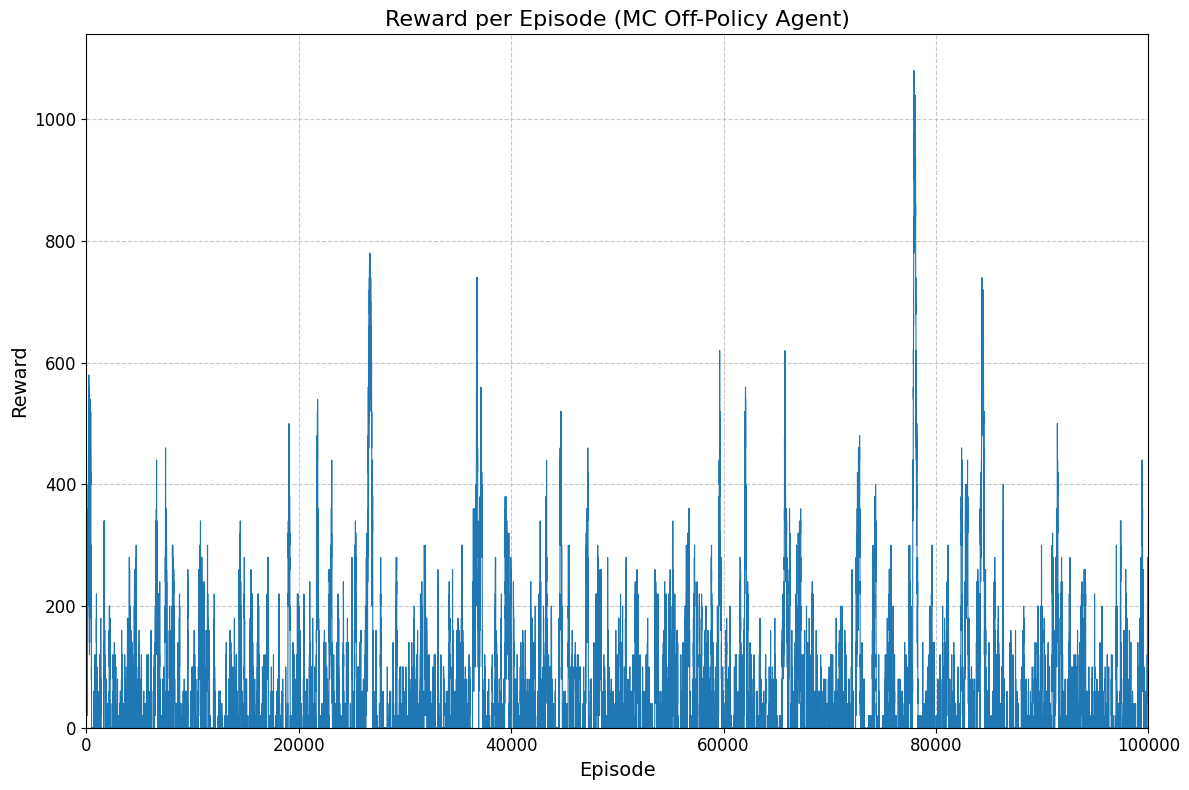

In [ ]:

# Create an instance of the environment
import matplotlib.pyplot as plt

def run_simulation(env, agent, num_episodes, epsilon, agent_name):
    all_episodes, rewards_per_episode = env.play(num_episodes, epsilon, agent)

    average_bankroll, win_rate, average_winnings = env.calculate_performance_metrics(num_episodes)

    print(f"{agent_name} - Average Bankroll: {average_bankroll:.4f}")
    print(f"{agent_name} - Win Rate: {win_rate:.5f}")
    print(f"{agent_name} - Average Winnings: {average_winnings:.4f}")

    plt.figure(figsize=(12, 8))
    plt.plot(range(1, num_episodes + 1), rewards_per_episode, color='#1f77b4', linewidth=0.8)
    plt.title(f"Reward per Episode ({agent_name})", fontsize=16)
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Reward", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.ylim(bottom=0)
    plt.xlim(0, num_episodes)
    plt.tight_layout()
    plt.show()

    return rewards_per_episode

# Main execution
if __name__ == "__main__":
    env = BlackjackEnvironment()

    # Define the Monte Carlo Off-Policy agent
    action_space = ['hit', 'stand', 'double_down', 'split']
    mc_off_policy_agent = MonteCarloOffPolicyAgent(action_space)

    # Define parameters for training
    num_episodes = 100000
    epsilon = 0.1

    # Train the Monte Carlo Off-Policy agent and plot results
    rewards_mc_off = run_simulation(env, mc_off_policy_agent, num_episodes, epsilon, "MC Off-Policy Agent")


Discount factor 0.7 and alpha value 0.5

In [ ]:
env = BlackjackEnvironment()

    # Define the Monte Carlo On-Policy agent
action_space = ['hit', 'stand', 'double_down', 'split']
mc_off_policy_agent = MonteCarloOffPolicyAgent(action_space)

    # Define parameters for training
num_episodes = 100000
epsilon = 0.1



all_episodes, rewards_per_episode = env.play(num_episodes, epsilon, mc_off_policy_agent)

average_bankroll, win_rate, average_winnings = env.calculate_performance_metrics(num_episodes)

print(f"{mc_off_policy_agent} - Average Bankroll: {average_bankroll:.4f}")
print(f"{mc_off_policy_agent} - Win Rate: {win_rate:.5f}")
print(f"{mc_off_policy_agent} - Average Winnings: {average_winnings:.4f}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 80
<__main__.MonteCarloOffPolicyAgent object at 0x7ed3f18ea3b0> - Average Bankroll: 118.7198
<__main__.MonteCarloOffPolicyAgent object at 0x7ed3f18ea3b0> - Win Rate: 0.39608
<__main__.MonteCarloOffPolicyAgent object at 0x7ed3f18ea3b0> - Average Winnings: 18.7198


Discount factor 0.8 and alpha value 0.5

In [ ]:
env = BlackjackEnvironment()

    # Define the Monte Carlo On-Policy agent
action_space = ['hit', 'stand', 'double_down', 'split']
mc_off_policy_agent = MonteCarloOffPolicyAgent(action_space)

    # Define parameters for training
num_episodes = 100000
epsilon = 0.1



all_episodes, rewards_per_episode = env.play(num_episodes, epsilon, mc_off_policy_agent)

average_bankroll, win_rate, average_winnings = env.calculate_performance_metrics(num_episodes)

print(f"{mc_off_policy_agent} - Average Bankroll: {average_bankroll:.4f}")
print(f"{mc_off_policy_agent} - Win Rate: {win_rate:.5f}")
print(f"{mc_off_policy_agent} - Average Winnings: {average_winnings:.4f}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 0
<__main__.MonteCarloOffPolicyAgent object at 0x7ed3bfb61240> - Average Bankroll: 119.3728
<__main__.MonteCarloOffPolicyAgent object at 0x7ed3bfb61240> - Win Rate: 0.40626
<__main__.MonteCarloOffPolicyAgent object at 0x7ed3bfb61240> - Average Winnings: 19.3728


Discount factor 0.99 and alpha value 0.5

In [ ]:
env = BlackjackEnvironment()

    # Define the Monte Carlo On-Policy agent
action_space = ['hit', 'stand', 'double_down', 'split']
mc_off_policy_agent = MonteCarloOffPolicyAgent(action_space)

    # Define parameters for training
num_episodes = 100000
epsilon = 0.1



all_episodes, rewards_per_episode = env.play(num_episodes, epsilon, mc_off_policy_agent)

average_bankroll, win_rate, average_winnings = env.calculate_performance_metrics(num_episodes)

print(f"{mc_off_policy_agent} - Average Bankroll: {average_bankroll:.4f}")
print(f"{mc_off_policy_agent} - Win Rate: {win_rate:.5f}")
print(f"{mc_off_policy_agent} - Average Winnings: {average_winnings:.4f}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 20
<__main__.MonteCarloOffPolicyAgent object at 0x7ed3f18ea530> - Average Bankroll: 113.8694
<__main__.MonteCarloOffPolicyAgent object at 0x7ed3f18ea530> - Win Rate: 0.39988
<__main__.MonteCarloOffPolicyAgent object at 0x7ed3f18ea530> - Average Winnings: 13.8694


2. **Implementation of Complete Point-Count System Environment and its RL Agents**

In [ ]:
class BlackjackEnvironmentCompleteCount:
    def __init__(self):
        self.deck = self.generate_deck()
        self.player_hand = []
        self.dealer_hand = []
        self.bankroll = 100
        self.bet = 20
        self.is_playing = False
        self.episode = []
        self.running_count = 0
        self.true_count = 0

    def generate_deck(self):
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        values = list(range(2, 11)) + ['jack', 'queen', 'king', 'ace']
        deck = []
        for value in values:
            for suit in suits:
                card = str(value) + '_' + suit
                deck.append(card)
        return deck

    def draw_card(self):
        if len(self.deck) == 0:
            self.check_deck()
        card = self.deck.pop(random.randint(0, len(self.deck) - 1))
        return card

    def check_deck(self):
        if len(self.deck) == 0:
            print("The deck is running out of cards. Creating a new deck...")
            self.deck = self.generate_deck()
            random.shuffle(self.deck)

    def reset(self):
        self.deck = self.generate_deck()
        random.shuffle(self.deck)
        self.player_hand = [self.draw_card(), self.draw_card()]
        self.dealer_hand = [self.draw_card(), self.draw_card()]
        self.bet = 20
        self.episode = []

    def card_value(self, card):
        value = card.split('_')[0]
        if value in ['jack', 'queen', 'king']:
            return 10
        elif value == 'ace':
            return 11
        else:
            return int(value)

    def hand_value(self, hand):
        value = sum(self.card_value(card) for card in hand)
        num_aces = sum(1 for card in hand if card.startswith('ace'))

        while value > 21 and num_aces > 0:
            value -= 10
            num_aces -= 1

        if num_aces > 0 and value > 21:
            value -= 10

        return value

    def is_busted(self, hand):
        return self.hand_value(hand) > 21

    def dealer_play(self):
        while self.hand_value(self.dealer_hand) < 17:
            self.dealer_hand.append(self.draw_card())
    def offer_insurance(self):
        player_value = self.hand_value(self.player_hand)
        dealer_upcard = self.card_value(self.dealer_hand[0])

        if player_value == 21 and dealer_upcard == 11:
            # Player has a natural blackjack and dealer upcard is an Ace
            # Pay 3:2 for blackjack
            self.bankroll += self.bet * 1.5
            # No need for insurance in this case
            self.insurance_bet = 0
        elif dealer_upcard == 11:
            # Dealer upcard is an Ace
            # Take insurance if the deck is rich in 10-value cards
            num_tens = sum(1 for card in self.deck if self.card_value(card) == 10)
            num_remaining_cards = len(self.deck)
            insurance_threshold = num_tens / num_remaining_cards
            if insurance_threshold > 0.3:
                # Insurance bet is half of the original bet
                insurance_amount = min(self.bankroll, self.bet / 2)
                self.bankroll -= insurance_amount
                self.insurance_bet = insurance_amount
                if self.hand_value(self.dealer_hand) == 21:
                    # Payout for the insurance bet
                    self.bankroll += self.insurance_bet * 2
                else:
                    pass
            else:
                self.insurance_bet = 0

    def double_down(self):
        if self.bet <= self.bankroll:
            self.bet *= 2
            self.player_hand.append(self.draw_card())

            if self.is_busted(self.player_hand):
                self.bankroll -= self.bet
                self.episode.append((self.get_state(), 'double_down', -1))
            else:
                self.dealer_play()
                player_value = self.hand_value(self.player_hand)
                dealer_value = self.hand_value(self.dealer_hand)

                if self.is_busted(self.dealer_hand) or player_value > dealer_value:
                    self.bankroll += self.bet
                    self.episode.append((self.get_state(), 'double_down', 1))
                elif dealer_value > player_value:
                    self.bankroll -= self.bet
                    self.episode.append((self.get_state(), 'double_down', -1))
                else:
                    self.episode.append((self.get_state(), 'double_down', 0))
        else:
            pass

    def place_bet(self):
        self.bet = 20

    def split_pair(self):
        if len(self.player_hand) == 2 and self.card_value(self.player_hand[0]) == self.card_value(self.player_hand[1]):
            card_value = self.card_value(self.player_hand[0])
            print(f"Splitting {card_value}'s...")
            # Create two separate hands from the pair of cards
            hand1 = [self.player_hand[0], self.draw_card()]
            hand2 = [self.player_hand[1], self.draw_card()]
            # Update player_hand to a list of split hands
            self.player_hand = [hand1, hand2]
        else:
            print("Split not possible. You must have a pair of cards with the same value.")

    def hit(self):
        self.player_hand.append(self.draw_card())

    def stand(self):
        self.dealer_play()
        player_value = self.hand_value(self.player_hand)
        dealer_value = self.hand_value(self.dealer_hand)

        if self.is_busted(self.dealer_hand):
            self.bankroll += self.bet
            self.episode.append((self.get_state(), 'stand', 1))
        elif player_value > dealer_value:
            self.bankroll += self.bet
            self.episode.append((self.get_state(), 'stand', 1))
        elif dealer_value > player_value:
            self.bankroll -= self.bet
            self.episode.append((self.get_state(), 'stand', -1))
        else:
            self.episode.append((self.get_state(), 'stand', 0))

    def get_state(self):
        return tuple(self.player_hand), self.dealer_hand[0]

    def update_running_count(self, card):
        value = self.card_value(card)
        if value in [2, 3, 4, 5, 6]:
            self.running_count += 1
        elif value in [10, 'jack', 'queen', 'king', 'ace']:
            self.running_count -= 1

    def calculate_true_count(self):
        num_remaining_cards = len(self.deck)
        num_decks_remaining = num_remaining_cards / 52
        self.true_count = self.running_count / num_decks_remaining

    def adjust_strategy_based_on_true_count(self):
        self.calculate_true_count()

        if self.true_count >= 1:
            # Increase the bet as the true count increases
            self.bet *= int(self.true_count)
            # Adjust playing strategy based on the true count
            player_value = self.hand_value(self.player_hand)
            dealer_upcard = self.card_value(self.dealer_hand[0])

            if self.true_count >= 1 and player_value == 16 and dealer_upcard in [9, 10, 11]:
                # True count is 1 or higher, player has a hand value of 16, and dealer's upcard is 9, 10, or Ace
                self.bankroll -= self.bet / 2
                return "surrender"
            elif self.true_count >= 2 and player_value == 10 and dealer_upcard != 10:
                # True count is 2 or higher, player has a hand value of 10, and dealer's upcard is not 10
                self.double_down()
                return "double_down"
            elif self.true_count >= 3 and player_value == 12 and dealer_upcard in [2, 3, 4, 5, 6]:
                # True count is 3 or higher, player has a hand value of 12, and dealer's upcard is 2, 3, 4, 5, or 6
                self.stand()
                return "stand"
            elif self.true_count >= 4 and player_value >= 13 and dealer_upcard in [2, 3, 4, 5, 6]:
                # True count is 4 or higher, player has a hand value of 13 or higher, and dealer's upcard is 2, 3, 4, 5, or 6
                self.stand()
                return "stand"
            elif self.true_count >= 1 and player_value >= 13 and dealer_upcard in [7, 8, 9, 10, 11]:
                # True count is 1 or higher, player has a hand value of 13 or higher, and dealer's upcard is 7, 8, 9, 10, or Ace
                self.hit()
                return "hit"
            elif self.true_count >= 3 and player_value >= 15 and dealer_upcard == 10:
                # True count is 3 or higher, player has a hand value of 15 or higher, and dealer's upcard is 10
                self.hit()
                return "hit"
            elif self.true_count >= 2 and player_value >= 17:
                # True count is 2 or higher and player has a hand value of 17 or higher
                self.stand()
                return "stand"
            else:
                pass
        else:
            pass

    def play_hand(self, hand):

        self.offer_insurance()
        while True:

            if isinstance(hand[0], list):

                for subhand in hand:
                    self.play_hand(subhand)
                break
            player_value = self.hand_value(hand)
            dealer_upcard = self.card_value(self.dealer_hand[0])
            action = self.adjust_strategy_based_on_true_count()
            if action == "surrender":
                self.bankroll -= self.bet / 2
                self.episode.append((self.get_state(), 'surrender', -1))
                break
            elif action == "double_down":
                self.double_down()
                self.episode.append((self.get_state(), 'double_down', 1))
                break
            elif action == "split":
                self.split_pair()
                self.episode.append((self.get_state(), 'split', 0))
                continue
            elif action == "hit":
                self.hit()
                if self.is_busted(hand):
                    self.bankroll -= min(self.bankroll, self.bet)
                    self.episode.append((self.get_state(), 'hit', -1))
                    break
            elif action == "stand":
                self.stand()
                self.episode.append((self.get_state(), 'stand', 0))
                break
            else:
                if player_value <= 8:
                    hand.append(self.draw_card())
                    if self.is_busted(hand):
                        self.bankroll -= min(self.bankroll, self.bet)
                        self.episode.append((self.get_state(), 'hit', -1))
                        break
                elif player_value >= 17:
                    self.dealer_play()
                    if self.is_busted(self.dealer_hand):
                        self.bankroll += self.bet
                        self.episode.append((self.get_state(), 'stand', 1))
                    else:
                        player_value = self.hand_value(hand)
                        dealer_value = self.hand_value(self.dealer_hand)
                        if player_value > dealer_value:
                            self.bankroll += self.bet
                            self.episode.append((self.get_state(), 'stand', 1))
                        elif dealer_value > player_value:
                            self.bankroll -= min(self.bankroll, self.bet)
                            self.episode.append((self.get_state(), 'stand', -1))
                        else:
                            self.episode.append((self.get_state(), 'stand', 0))
                    break
                elif 2 <= dealer_upcard <= 6:
                    self.dealer_play()
                    if self.is_busted(self.dealer_hand):
                        self.bankroll += self.bet
                        self.episode.append((self.get_state(), 'stand', 1))
                    else:
                        player_value = self.hand_value(hand)
                        dealer_value = self.hand_value(self.dealer_hand)
                        if player_value > dealer_value:
                            self.bankroll += self.bet
                            self.episode.append((self.get_state(), 'stand', 1))
                        elif dealer_value > player_value:
                            self.bankroll -= min(self.bankroll, self.bet)
                            self.episode.append((self.get_state(), 'stand', -1))
                        else:
                            self.episode.append((self.get_state(), 'stand', 0))
                    break
                elif player_value == 9 or player_value == 10 or player_value == 11:
                    self.double_down()
                    self.episode.append((self.get_state(), 'double_down', 1))
                    break
                elif player_value == self.card_value(hand[0]):
                    self.split_pair()
                    self.episode.append((self.get_state(), 'split', 0))
                    for subhand in self.player_hand:
                        self.episode.append((self.get_state(), 'split', 0))
                        self.play_hand(subhand)
                    break
                else:
                    hand.append(self.draw_card())
                    if self.is_busted(hand):
                        self.bankroll -= min(self.bankroll, self.bet)
                        self.episode.append((self.get_state(), 'hit', -1))
                        break
            return self.bankroll

    def get_episode(self):
        # Wrap the episode list in another list
        return [self.episode]

    def play(self, num_episodes, epsilon, agent):
        print("Welcome to Blackjack!")
        print(f"Your current bankroll: {self.bankroll}")
        self.is_playing = True
        current_episode = 0
        all_episodes = []
        rewards_per_episode = []  # To store rewards per episode

        for _ in range(num_episodes):
            self.reset()
            self.place_bet()
            self.episode = []
            self.play_hand(self.player_hand)
            episode = self.get_episode()
            all_episodes.extend(episode)
            rewards_per_episode.append(self.bankroll - 100)  # Calculate reward per episode

            if _ < num_episodes - 1:
                self.episode = []

        print("\nThank you for playing Blackjack!")
        print(f"Final Bankroll: {self.bankroll}")

        current_episode = _ + 1
        agent.update_policy(all_episodes)

        return all_episodes, rewards_per_episode


    def calculate_performance_metrics(self, num_episodes):
        total_bankroll = 0
        total_winnings = 0
        total_wins = 0

        for _ in range(num_episodes):
            self.reset()
            self.place_bet()
            self.play_hand(self.player_hand)

            total_bankroll += self.bankroll
            total_winnings += self.bankroll - 100
            if self.bankroll > 100:
                total_wins += 1

        average_bankroll = total_bankroll / num_episodes
        win_rate = total_wins / num_episodes
        average_winnings = total_winnings / num_episodes

        return average_bankroll, win_rate, average_winnings




**Monte Carlo On-Policy and off-Policy agents for Complete Card Count system**

In [ ]:
import random
import numpy as np

class MonteCarloAgent:
    def __init__(self, actions, epsilon=0.1, gamma=0.9):
        self.actions = actions
        self.epsilon = epsilon
        self.gamma = gamma
        self.Q = {}
        self.returns = {}
        self.policy = {}

    def get_action(self, state):
        if state not in self.policy:
            return random.choice(self.actions)
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        return max(self.actions, key=lambda a: self.Q.get((state, a), 0))

    def update_policy(self, episodes):
        for episode in episodes:
            G = 0
            for t in range(len(episode) - 1, -1, -1):
                state, action, reward = episode[t]
                G = self.gamma * G + reward
                if (state, action) not in [(x[0], x[1]) for x in episode[:t]]:
                    if (state, action) not in self.returns:
                        self.returns[(state, action)] = []
                    self.returns[(state, action)].append(G)
                    self.Q[(state, action)] = np.mean(self.returns[(state, action)])
                    self.policy[state] = max(self.actions, key=lambda a: self.Q.get((state, a), 0))

class OffPolicyMonteCarloAgent(MonteCarloAgent):
    def __init__(self, actions, epsilon=0.1, gamma=0.9):
        super().__init__(actions, epsilon, gamma)
        self.C = {}

    def update_policy(self, episodes):
        for episode in episodes:
            G = 0
            W = 1
            for t in range(len(episode) - 1, -1, -1):
                state, action, reward = episode[t]
                G = self.gamma * G + reward
                if (state, action) not in self.C:
                    self.C[(state, action)] = 0
                self.C[(state, action)] += W
                self.Q[(state, action)] = self.Q.get((state, action), 0) + (W / self.C[(state, action)]) * (G - self.Q.get((state, action), 0))
                if action != self.get_action(state):
                    break
                W *= 1 / ((1 - self.epsilon) + (self.epsilon / len(self.actions)))
            self.policy = {s: max(self.actions, key=lambda a: self.Q.get((s, a), 0)) for s in set(s for s, _, _ in episode)}

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 180.0
MC On-Policy Agent - Average Bankroll: 117.1572
MC On-Policy Agent - Win Rate: 0.38951
MC On-Policy Agent - Average Winnings: 17.1572


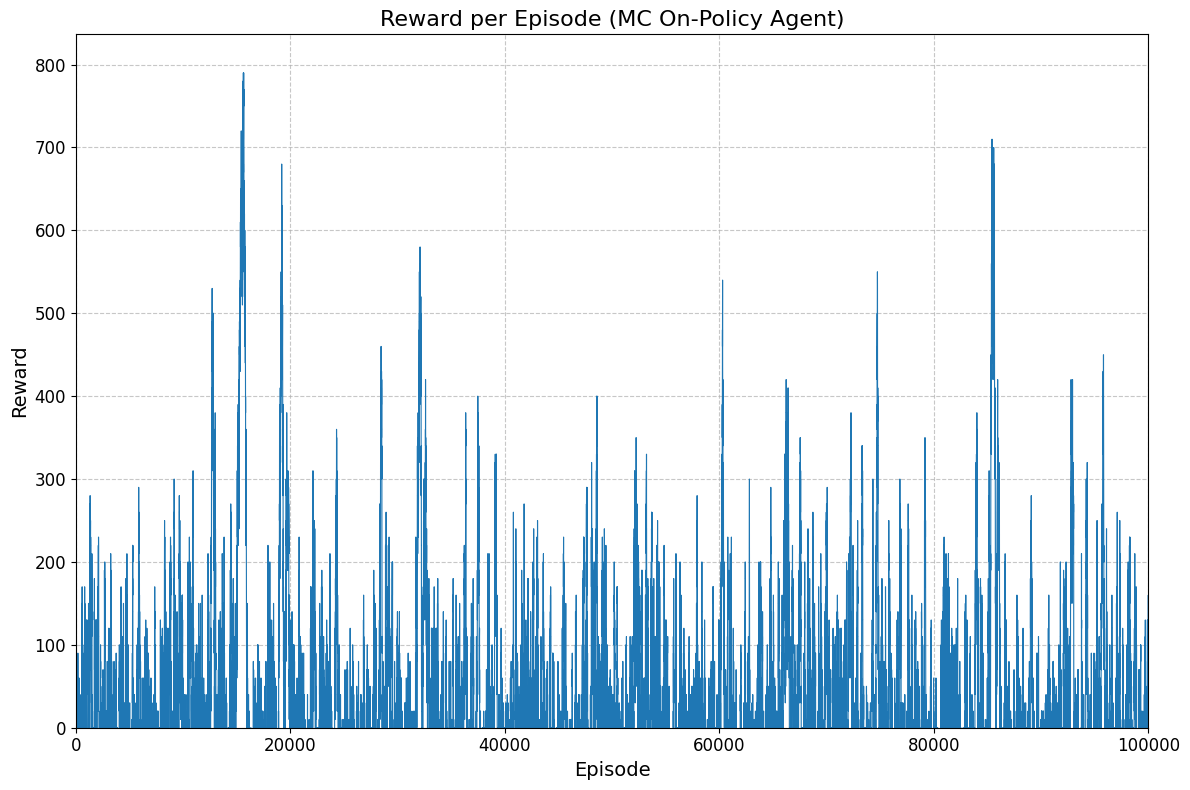

Welcome to Blackjack!
Your current bankroll: 0.0

Thank you for playing Blackjack!
Final Bankroll: 210.0
MC Off-Policy Agent - Average Bankroll: 121.2545
MC Off-Policy Agent - Win Rate: 0.41566
MC Off-Policy Agent - Average Winnings: 21.2545


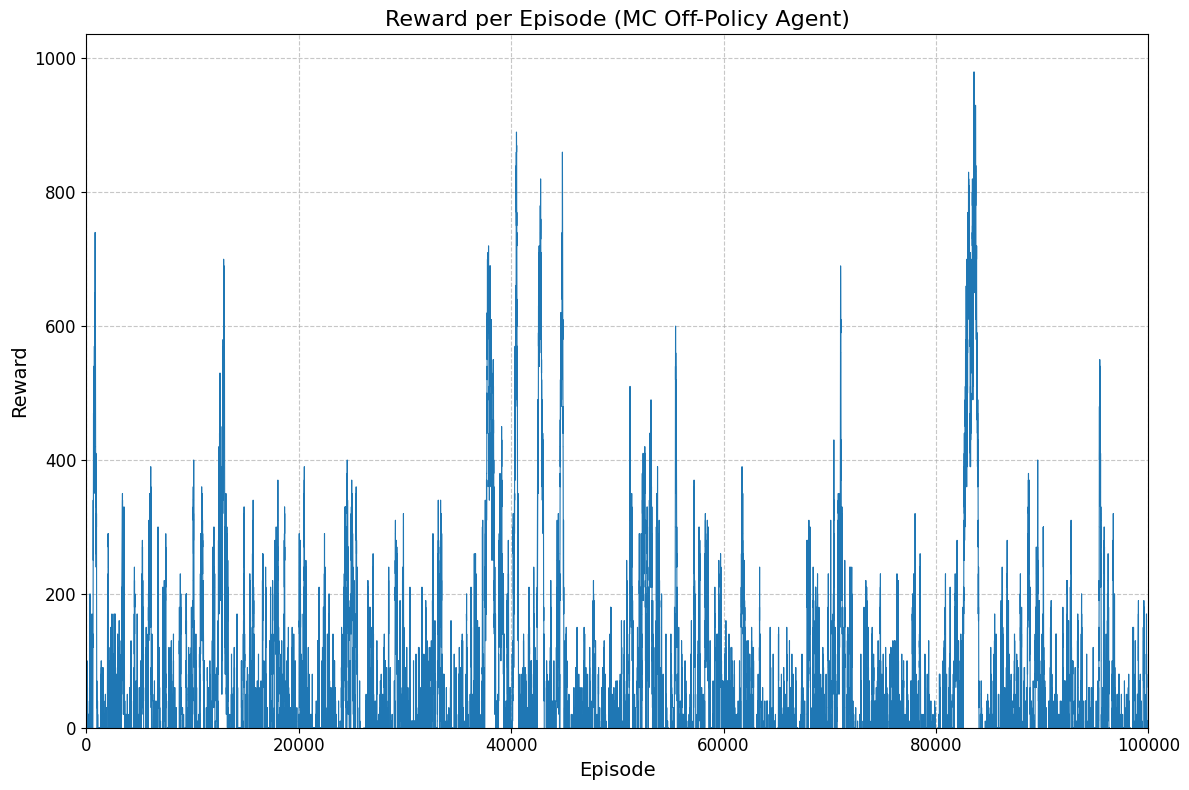

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# The line above is specific to Jupyter/Colab to display plots inline

def run_simulation(env, agent, num_episodes, agent_name):
    episodes, rewards = env.play(num_episodes, agent.epsilon, agent)

    avg_bankroll, win_rate, avg_winnings = env.calculate_performance_metrics(num_episodes)

    print(f"{agent_name} - Average Bankroll: {avg_bankroll:.4f}")
    print(f"{agent_name} - Win Rate: {win_rate:.5f}")
    print(f"{agent_name} - Average Winnings: {avg_winnings:.4f}")

    # Generate plot
    plt.figure(figsize=(12, 8))
    plt.plot(range(1, num_episodes + 1), rewards, color='#1f77b4', linewidth=0.8)
    plt.title(f"Reward per Episode ({agent_name})", fontsize=16)
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Reward", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tick_params(axis='both', which='major', labelsize=12)

    # Adjust y-axis to start from 0
    plt.ylim(bottom=0)

    # Increase the density of data points
    plt.xlim(0, num_episodes)

    # Add some padding to the plot
    plt.tight_layout()

    # Show the plot
    plt.show()

    return rewards

# Main execution
if __name__ == "__main__":
    env = BlackjackEnvironmentCompleteCount()
    actions = ['hit', 'stand', 'double_down', 'split']
    num_episodes = 100000  # 100,000 episodes
    epsilon = 0.1
    gamma = 0.9

    # On-policy Monte Carlo
    on_policy_agent = MonteCarloAgent(actions, epsilon=epsilon, gamma=gamma)
    on_policy_rewards = run_simulation(env, on_policy_agent, num_episodes, "MC On-Policy Agent")

    # Off-policy Monte Carlo
    off_policy_agent = OffPolicyMonteCarloAgent(actions, epsilon=epsilon, gamma=gamma)
    off_policy_rewards = run_simulation(env, off_policy_agent, num_episodes, "MC Off-Policy Agent")

In [ ]:
# Main execution
def run_simulation(env, agent, num_episodes, agent_name):
    episodes, rewards = env.play(num_episodes, agent.epsilon, agent)

    avg_bankroll, win_rate, avg_winnings = env.calculate_performance_metrics(num_episodes)

    print(f"{agent_name} - Average Bankroll: {avg_bankroll:.4f}")
    print(f"{agent_name} - Win Rate: {win_rate:.5f}")
    print(f"{agent_name} - Average Winnings: {avg_winnings:.4f}")


# Main execution
if __name__ == "__main__":
    env = BlackjackEnvironmentCompleteCount()
    actions = ['hit', 'stand', 'double_down', 'split']
    num_episodes = 100000  # 100,000 episodes
    epsilon = 0.1
    gamma = 0.99

    # On-policy Monte Carlo
    on_policy_agent = MonteCarloAgent(actions, epsilon=epsilon, gamma=gamma)
    on_policy_rewards = run_simulation(env, on_policy_agent, num_episodes, "MC On-Policy Agent")

    # Off-policy Monte Carlo
    off_policy_agent = OffPolicyMonteCarloAgent(actions, epsilon=epsilon, gamma=gamma)
    off_policy_rewards = run_simulation(env, off_policy_agent, num_episodes, "MC Off-Policy Agent")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 150.0
MC On-Policy Agent - Average Bankroll: 125.1784
MC On-Policy Agent - Win Rate: 0.42611
MC On-Policy Agent - Average Winnings: 25.1784
Welcome to Blackjack!
Your current bankroll: 30.0

Thank you for playing Blackjack!
Final Bankroll: 0.0
MC Off-Policy Agent - Average Bankroll: 124.8926
MC Off-Policy Agent - Win Rate: 0.41587
MC Off-Policy Agent - Average Winnings: 24.8926


**SARSA And Temporal Difference Agents for Complete Card Count**

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

class SARSAAgent:
    def __init__(self, actions, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        q_values = [self.get_q_value(state, action) for action in self.actions]
        max_q = max(q_values)
        return self.actions[q_values.index(max_q)]

    def update_q_value(self, state, action, reward, next_state, next_action):
        current_q = self.get_q_value(state, action)
        next_q = self.get_q_value(next_state, next_action) if next_action else 0
        new_q = current_q + self.alpha * (reward + self.gamma * next_q - current_q)
        self.q_table[(state, action)] = new_q

    def update_policy(self, episodes):
        for episode in episodes:
            if len(episode) < 2:
                continue
            for i in range(len(episode) - 1):
                state, action, reward = episode[i]
                next_state, next_action, _ = episode[i + 1]
                self.update_q_value(state, action, reward, next_state, next_action)
            # Last step
            state, action, reward = episode[-1]
            self.update_q_value(state, action, reward, None, None)

class TDAgent:
    def __init__(self, actions, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        q_values = [self.get_q_value(state, action) for action in self.actions]
        max_q = max(q_values)
        return self.actions[q_values.index(max_q)]

    def update_q_value(self, state, action, reward, next_state):
        current_q = self.get_q_value(state, action)
        if next_state is None:
            next_q = 0
        else:
            next_q = max([self.get_q_value(next_state, a) for a in self.actions])
        new_q = current_q + self.alpha * (reward + self.gamma * next_q - current_q)
        self.q_table[(state, action)] = new_q

    def update_policy(self, episodes):
        for episode in episodes:
            if len(episode) == 0:
                continue
            for i in range(len(episode) - 1):
                state, action, reward = episode[i]
                next_state, next_action, _ = episode[i + 1]
                self.update_q_value(state, action, reward, next_state)
            # Last step
            state, action, reward = episode[-1]
            self.update_q_value(state, action, reward, None)



Experiment with differnet Discount Factor and alpha values

Discount Factor 0.9 and alpha 0.5

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 20.0
SARSA On-Policy Agent - Average Bankroll: 116.9419
SARSA On-Policy Agent - Win Rate: 0.40541
SARSA On-Policy Agent - Average Winnings: 16.9419


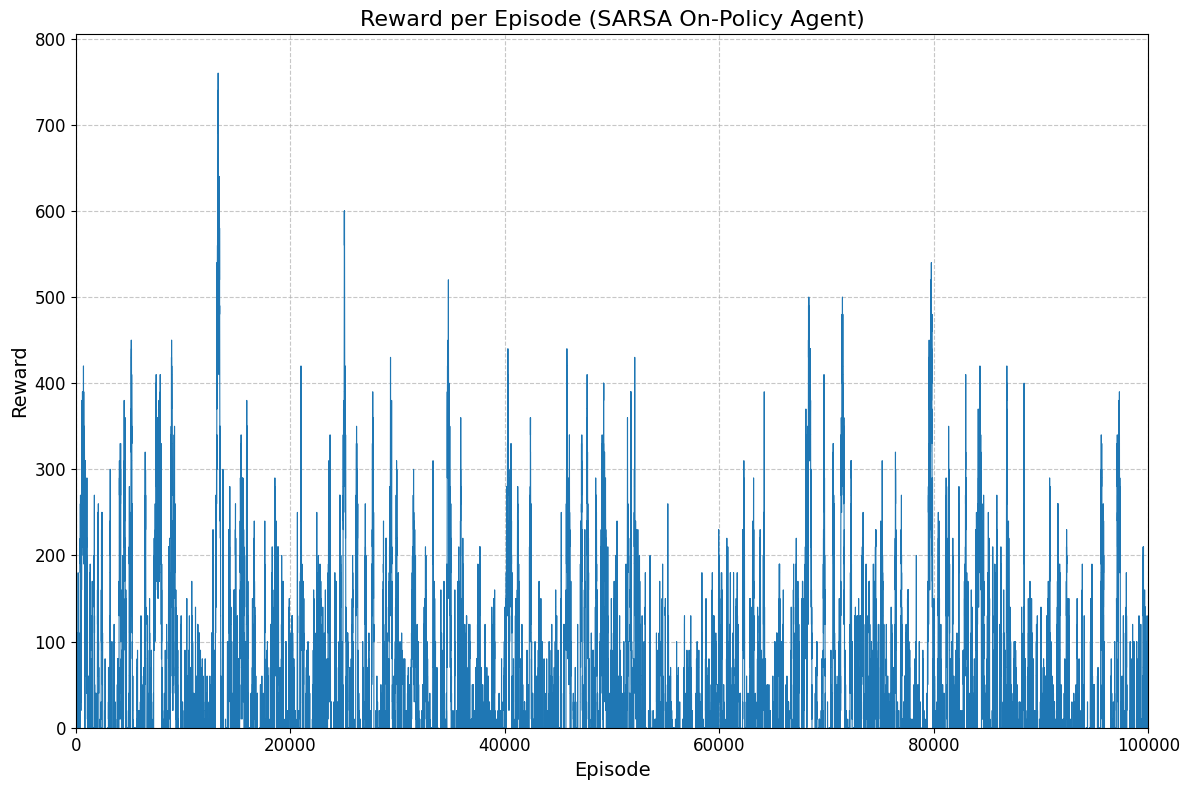

Welcome to Blackjack!
Your current bankroll: 40.0

Thank you for playing Blackjack!
Final Bankroll: 150.0
TD Off-Policy Agent - Average Bankroll: 117.3808
TD Off-Policy Agent - Win Rate: 0.39955
TD Off-Policy Agent - Average Winnings: 17.3808


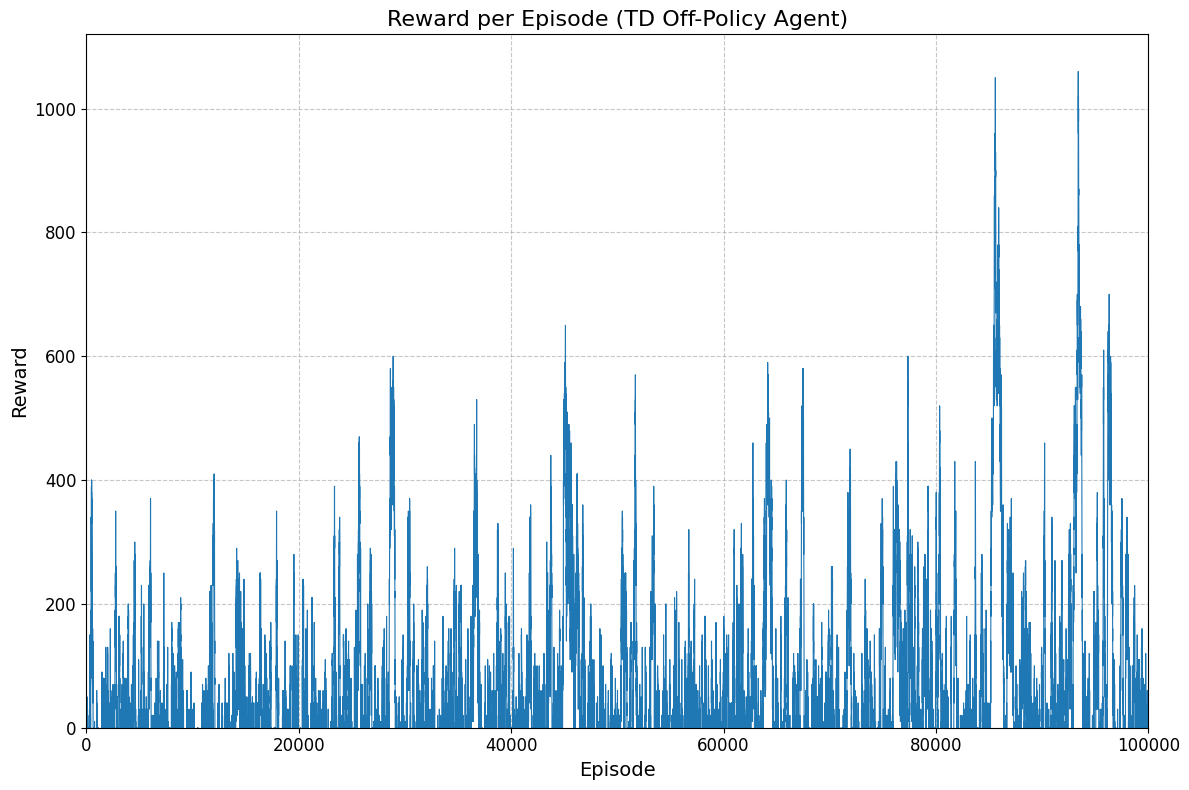

In [ ]:
def run_simulation(env, agent, num_episodes, agent_name):
    all_episodes, rewards_per_episode = env.play(num_episodes, agent.epsilon, agent)
    average_bankroll, win_rate, average_winnings = env.calculate_performance_metrics(num_episodes)

    print(f"{agent_name} - Average Bankroll: {average_bankroll:.4f}")
    print(f"{agent_name} - Win Rate: {win_rate:.5f}")
    print(f"{agent_name} - Average Winnings: {average_winnings:.4f}")

    plt.figure(figsize=(12, 8))
    plt.plot(range(1, num_episodes + 1), rewards_per_episode, color='#1f77b4', linewidth=0.8)
    plt.title(f"Reward per Episode ({agent_name})", fontsize=16)
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Reward", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.ylim(bottom=0)
    plt.xlim(0, num_episodes)
    plt.tight_layout()
    plt.show()

    return rewards_per_episode

# Main execution
if __name__ == "__main__":
    env = BlackjackEnvironmentCompleteCount()
    actions = ['hit', 'stand', 'double_down', 'split', 'surrender']
    num_episodes = 100000
    epsilon = 0.1
    gamma = 0.9
    alpha = 0.5

    # SARSA (On-policy)
    sarsa_agent = SARSAAgent(actions, alpha=alpha, gamma=gamma, epsilon=epsilon)
    sarsa_rewards = run_simulation(env, sarsa_agent, num_episodes, "SARSA On-Policy Agent")

    # TD (Off-policy)
    td_agent = TDAgent(actions, alpha=alpha, gamma=gamma, epsilon=epsilon)
    td_rewards = run_simulation(env, td_agent, num_episodes, "TD Off-Policy Agent")

Discount factor 0.7 and alpha value 0.5

In [ ]:
def run_simulation(env, agent, num_episodes, agent_name):
    all_episodes, rewards_per_episode = env.play(num_episodes, agent.epsilon, agent)
    average_bankroll, win_rate, average_winnings = env.calculate_performance_metrics(num_episodes)

    print(f"{agent_name} - Average Bankroll: {average_bankroll:.4f}")
    print(f"{agent_name} - Win Rate: {win_rate:.5f}")
    print(f"{agent_name} - Average Winnings: {average_winnings:.4f}")



    return rewards_per_episode

# Main execution
if __name__ == "__main__":
    env = BlackjackEnvironmentCompleteCount()
    actions = ['hit', 'stand', 'double_down', 'split', 'surrender']
    num_episodes = 100000
    epsilon = 0.1
    gamma = 0.7
    alpha = 0.5

    # SARSA (On-policy)
    sarsa_agent = SARSAAgent(actions, alpha=alpha, gamma=gamma, epsilon=epsilon)
    sarsa_rewards = run_simulation(env, sarsa_agent, num_episodes, "SARSA On-Policy Agent")

    # TD (Off-policy)
    td_agent = TDAgent(actions, alpha=alpha, gamma=gamma, epsilon=epsilon)
    td_rewards = run_simulation(env, td_agent, num_episodes, "TD Off-Policy Agent")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 40.0
SARSA On-Policy Agent - Average Bankroll: 119.2970
SARSA On-Policy Agent - Win Rate: 0.38688
SARSA On-Policy Agent - Average Winnings: 19.2970
Welcome to Blackjack!
Your current bankroll: 210.0

Thank you for playing Blackjack!
Final Bankroll: 60.0
TD Off-Policy Agent - Average Bankroll: 109.1955
TD Off-Policy Agent - Win Rate: 0.36303
TD Off-Policy Agent - Average Winnings: 9.1955


Discount Factor 0.8 and alpha 0.5

In [ ]:
def run_simulation(env, agent, num_episodes, agent_name):
    all_episodes, rewards_per_episode = env.play(num_episodes, agent.epsilon, agent)
    average_bankroll, win_rate, average_winnings = env.calculate_performance_metrics(num_episodes)

    print(f"{agent_name} - Average Bankroll: {average_bankroll:.4f}")
    print(f"{agent_name} - Win Rate: {win_rate:.5f}")
    print(f"{agent_name} - Average Winnings: {average_winnings:.4f}")



    return rewards_per_episode

# Main execution
if __name__ == "__main__":
    env = BlackjackEnvironmentCompleteCount()
    actions = ['hit', 'stand', 'double_down', 'split', 'surrender']
    num_episodes = 100000
    epsilon = 0.1
    gamma = 0.8
    alpha = 0.5

    # SARSA (On-policy)
    sarsa_agent = SARSAAgent(actions, alpha=alpha, gamma=gamma, epsilon=epsilon)
    sarsa_rewards = run_simulation(env, sarsa_agent, num_episodes, "SARSA On-Policy Agent")

    # TD (Off-policy)
    td_agent = TDAgent(actions, alpha=alpha, gamma=gamma, epsilon=epsilon)
    td_rewards = run_simulation(env, td_agent, num_episodes, "TD Off-Policy Agent")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 70.0
SARSA On-Policy Agent - Average Bankroll: 108.4111
SARSA On-Policy Agent - Win Rate: 0.36506
SARSA On-Policy Agent - Average Winnings: 8.4111
Welcome to Blackjack!
Your current bankroll: 0.0

Thank you for playing Blackjack!
Final Bankroll: 140.0
TD Off-Policy Agent - Average Bankroll: 112.6592
TD Off-Policy Agent - Win Rate: 0.39178
TD Off-Policy Agent - Average Winnings: 12.6592


Discount Factor 0.99 and alpha 0.5

In [ ]:
def run_simulation(env, agent, num_episodes, agent_name):
    all_episodes, rewards_per_episode = env.play(num_episodes, agent.epsilon, agent)
    average_bankroll, win_rate, average_winnings = env.calculate_performance_metrics(num_episodes)

    print(f"{agent_name} - Average Bankroll: {average_bankroll:.4f}")
    print(f"{agent_name} - Win Rate: {win_rate:.5f}")
    print(f"{agent_name} - Average Winnings: {average_winnings:.4f}")



    return rewards_per_episode

# Main execution
if __name__ == "__main__":
    env = BlackjackEnvironmentCompleteCount()
    actions = ['hit', 'stand', 'double_down', 'split', 'surrender']
    num_episodes = 100000
    epsilon = 0.1
    gamma = 0.99
    alpha = 0.5

    # SARSA (On-policy)
    sarsa_agent = SARSAAgent(actions, alpha=alpha, gamma=gamma, epsilon=epsilon)
    sarsa_rewards = run_simulation(env, sarsa_agent, num_episodes, "SARSA On-Policy Agent")

    # TD (Off-policy)
    td_agent = TDAgent(actions, alpha=alpha, gamma=gamma, epsilon=epsilon)
    td_rewards = run_simulation(env, td_agent, num_episodes, "TD Off-Policy Agent")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 520.0
SARSA On-Policy Agent - Average Bankroll: 113.6949
SARSA On-Policy Agent - Win Rate: 0.38957
SARSA On-Policy Agent - Average Winnings: 13.6949
Welcome to Blackjack!
Your current bankroll: 230.0

Thank you for playing Blackjack!
Final Bankroll: 460.0
TD Off-Policy Agent - Average Bankroll: 127.0234
TD Off-Policy Agent - Win Rate: 0.39696
TD Off-Policy Agent - Average Winnings: 27.0234
